$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bm}[1]{{\bf #1}}
\newcommand{\bb}[1]{\bm{\mathrm{#1}}}
$$

# Part 3: Generative Adversarial Networks
<a id=part3></a>

In this part we will implement and train a generative adversarial network and apply it to the task of image generation.

In [3]:
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

test = unittest.TestCase()
plt.rcParams.update({'font.size': 12})
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Obtaining the dataset
<a id=part3_1></a>

We'll use the same data as in Part 2.

But again, you can use a custom dataset, by editing the `PART3_CUSTOM_DATA_URL` variable in `hw3/answers.py`.

In [5]:
import cs236781.plot as plot
import cs236781.download
from hw3.answers import PART3_CUSTOM_DATA_URL as CUSTOM_DATA_URL

DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)

File /home/ofir.s/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/ofir.s/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/ofir.s/.pytorch-datasets/lfw/George_W_Bush


Create a `Dataset` object that will load the extraced images:

In [6]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)

OK, let's see what we got. You can run the following block multiple times to display a random subset of images from the dataset.

Found 530 images in dataset folder.


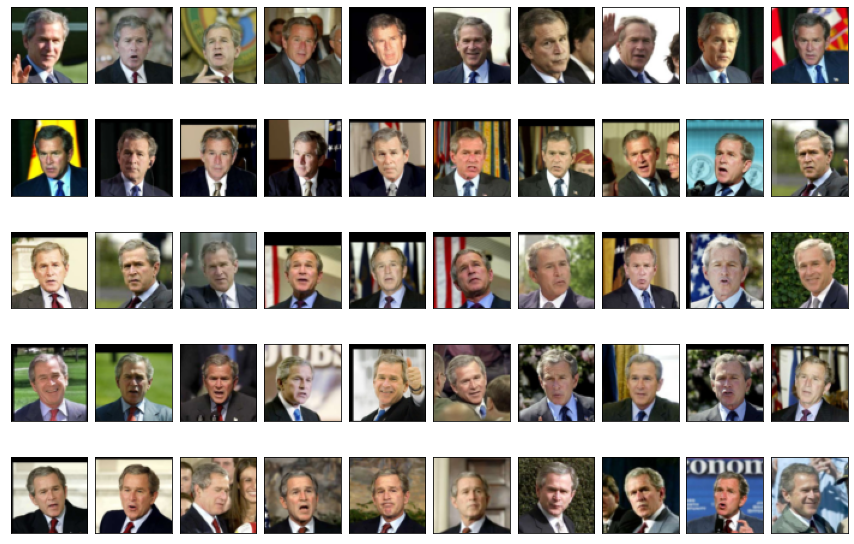

In [7]:
_ = plot.dataset_first_n(ds_gwb, 50, figsize=(15,10), nrows=5)
print(f'Found {len(ds_gwb)} images in dataset folder.')

In [8]:
x0, y0 = ds_gwb[0]
x0 = x0.unsqueeze(0).to(device)
print(x0.shape)

test.assertSequenceEqual(x0.shape, (1, 3, im_size, im_size))

torch.Size([1, 3, 64, 64])


## Generative Adversarial Nets (GANs)
<a id=part3_2></a>

GANs, first proposed in a [paper](https://arxiv.org/pdf/1406.2661.pdf) by Ian Goodfellow in 2014 are today arguably the most popular type of generative model. GANs are currently producing state of the art
results in generative tasks over many different domains.

In a GAN model, two different neural networks compete against each other: A **generator** and a **discriminator**.

- The Generator, which we'll denote as $\Psi _{\bb{\gamma}} : \mathcal{U} \rightarrow \mathcal{X}$, maps a latent-space variable
$\bb{u}\sim\mathcal{N}(\bb{0},\bb{I})$ to an instance-space variable $\bb{x}$ (e.g. an image).
Thus a parametric evidence distribution $p_{\bb{\gamma}}(\bb{X})$ is generated,
which we typically would like to be as close as possible to the real evidence distribution, $p(\bb{X})$.

- The Discriminator, $\Delta _{\bb{\delta}} : \mathcal{X} \rightarrow [0,1]$, is a network which,
given an instance-space variable $\bb{x}$, returns the  probability that $\bb{x}$ is real, i.e. that $\bb{x}$
was sampled from $p(\bb{X})$ and not $p_{\bb{\gamma}}(\bb{X})$.


<img src="imgs/gan.jpg" />

### Training GANs
<a id=part3_3></a>

The generator is trained to generate "fake" instances which will maximally fool the
discriminator into returning that they're real. Mathematically, the generator's parameters
$\bb{\gamma}$ should be chosen such as to **maximize** the expression
$$
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

The discriminator is trained to classify between real images, coming from the training set,
and fake images generated by the generator.
Mathematically, the discriminator's parameters $\bb{\delta}$ should be chosen such as to
**maximize** the expression
$$
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

These two competing objectives can thus be expressed as the following min-max optimization:
$$
\min _{\bb{\gamma}} \max _{\bb{\delta}} \,
\mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

A key insight into GANs is that we can interpret the above maximum as the *loss* with respect to
$\bb{\gamma}$:

$$
L({\bb{\gamma}}) =
\max _{\bb{\delta}} \, \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, + \,
  \mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

This means that the generator's loss function trains together with the generator
itself in an adversarial manner. In contrast, when training our VAE we used a fixed L2 norm
as a data loss term.

### Model Implementation
<a id=part3_4></a>

We'll now implement a Deep Convolutional GAN (DCGAN) model.
See the DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) for architecture ideas and tips for training.

**TODO**: Implement the `Discriminator` class in the `hw3/gan.py` module.
If you wish you can reuse the `EncoderCNN` class from the VAE model as the first part of the Discriminator.

In [9]:
import hw3.gan as gan

dsc = gan.Discriminator(in_size=x0[0].shape).to(device)
print(dsc)

d0 = dsc(x0)
print(d0.shape)

test.assertSequenceEqual(d0.shape, (1,1))

Discriminator(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
torch.Size([1, 1])


**TODO**: Implement the `Generator` class in the `hw3/gan.py` module.
If you wish you can reuse the `DecoderCNN` class from the VAE model as the last part of the Generator.

In [7]:
z_dim = 128
gen = gan.Generator(z_dim, 4).to(device)
print(gen)

z = torch.randn(1, z_dim).to(device)
xr = gen(z)
print(xr.shape)

test.assertSequenceEqual(x0.shape, xr.shape)

Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
torch.Size([1, 3, 64, 64])


### Loss Implementation
<a id=part3_5></a>

Let's begin with the discriminator's loss function.
Based on the above we can flip the sign and say we want to update the 
Discriminator's parameters $\bb{\delta}$ so that they **minimize** the expression
$$
- \mathbb{E} _{\bb{x} \sim p(\bb{X}) } \log \Delta _{\bb{\delta}}(\bb{x})  \, - \,
\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (1-\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) )).
$$

We're using the Discriminator twice in this expression;
once to classify data from the real data distribution and
once again to classify generated data.
Therefore our loss should be computed based on these two terms.
Notice that since the discriminator returns a probability, we can formulate the above as two cross-entropy losses.

GANs are notoriously diffucult to train.
One common trick for improving GAN stability during training is to make the classification labels noisy for the discriminator. This can be seen as a form of regularization, to help prevent the discriminator from overfitting.

We'll incorporate this idea into our loss function. Instead of labels being equal to 0 or 1, we'll make them
"fuzzy", i.e. random numbers in the ranges $[0\pm\epsilon]$ and $[1\pm\epsilon]$.

**TODO**: Implement the `discriminator_loss_fn()` function in the `hw3/gan.py` module.

In [8]:
from hw3.gan import discriminator_loss_fn
torch.manual_seed(42)

y_data = torch.rand(10) * 10
y_generated = torch.rand(10) * 10

loss = discriminator_loss_fn(y_data, y_generated, data_label=1, label_noise=0.3)
print(loss)

test.assertAlmostEqual(loss.item(), 6.4808731, delta=1e-5)

tensor(6.4809)


Similarly, the generator's parameters $\bb{\gamma}$ should **minimize** the expression
$$
-\mathbb{E} _{\bb{z} \sim p(\bb{Z}) } \log (\Delta _{\bb{\delta}}(\Psi _{\bb{\gamma}} (\bb{z}) ))
$$

which can also be seen as a cross-entropy term. This corresponds to "fooling" the discriminator; Notice that the gradient of the loss w.r.t $\bb{\gamma}$ using this expression also depends on $\bb{\delta}$.

**TODO**: Implement the `generator_loss_fn()` function in the `hw3/gan.py` module.

In [9]:
from hw3.gan import generator_loss_fn
torch.manual_seed(42)

y_generated = torch.rand(20) * 10

loss = generator_loss_fn(y_generated, data_label=1)
print(loss)

test.assertAlmostEqual(loss.item(), 0.0222969, delta=1e-3)

tensor(0.0223)


### Sampling
<a id=part3_6></a>

Sampling from a GAN is straightforward, since it learns to generate data from an isotropic Gaussian latent space distribution.

There is an important nuance however. Sampling is required during the process of training the GAN, since
we generate fake images to show the discriminator.
As you'll seen in the next section,  in some cases we'll need our samples to have gradients (i.e., to be part of
the Generator's computation graph).

**TODO**: Implement the `sample()` method in the `Generator` class within the `hw3/gan.py` module.

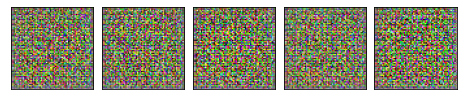

In [10]:
samples = gen.sample(5, with_grad=False)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNone(samples.grad_fn)
_ = plot.tensors_as_images(samples.cpu())

samples = gen.sample(5, with_grad=True)
test.assertSequenceEqual(samples.shape, (5, *x0.shape[1:]))
test.assertIsNotNone(samples.grad_fn)

### Training
<a id=part3_7></a>

Training GANs is a bit different since we need to train two models simultaneously, each with it's own separate loss function and optimizer. We'll implement the training logic as a function that handles one batch of data
and updates both the discriminator and the generator based on it.

As mentioned above, GANs are considered hard to train. To get some ideas and tips you can see this [paper](https://arxiv.org/pdf/1606.03498.pdf), this list of ["GAN hacks"](https://github.com/soumith/ganhacks) or just do it the hard way :)

**TODO**:
1. Implement the `train_batch` function in the `hw3/gan.py` module.
2. Tweak the hyperparameters in the `part3_gan_hyperparams()` function within the `hw3/answers.py` module.

In [14]:
import torch.optim as optim
from torch.utils.data import DataLoader
from hw3.answers import part3_gan_hyperparams
torch.manual_seed(42)

# Hyperparams
hp = part3_gan_hyperparams()
batch_size = hp['batch_size']
z_dim = hp['z_dim']

# Data
dl_train = DataLoader(ds_gwb, batch_size, shuffle=True)
im_size = ds_gwb[0][0].shape

# Model
dsc = gan.Discriminator(im_size).to(device)
gen = gan.Generator(z_dim, featuremap_size=4).to(device)
print(len(list(dsc.parameters())))
print(len(list(gen.parameters())))

# Optimizer
def create_optimizer(model_params, opt_params):
    opt_params = opt_params.copy()
    optimizer_type = opt_params['type']
    opt_params.pop('type')
    return optim.__dict__[optimizer_type](model_params, **opt_params)
dsc_optimizer = create_optimizer(dsc.parameters(), hp['discriminator_optimizer'])
gen_optimizer = create_optimizer(gen.parameters(), hp['generator_optimizer'])

# Loss
def dsc_loss_fn(y_data, y_generated):
    return gan.discriminator_loss_fn(y_data, y_generated, hp['data_label'], hp['label_noise'])

def gen_loss_fn(y_generated):
    return gan.generator_loss_fn(y_generated, hp['data_label'])

# Training
checkpoint_file = 'checkpoints/gan'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

# Show hypers
print(hp)

11
13
{'batch_size': 53, 'z_dim': 100, 'data_label': 1, 'label_noise': 0.1, 'discriminator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999)}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.0002, 'betas': (0.5, 0.999)}}


In [15]:
print(gen)
print(dsc)

Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)
Discriminator(
  (conv): Sequential(
    (0):

**TODO**:
1. Implement the `save_checkpoint` function in the `hw3.gan` module. You can decide on your own criterion regarding whether to save a checkpoint at the end of each epoch.
1. Run the following block to train. It will sample some images from your model every few epochs so you can see the progress.
2. When you're satisfied with your results, rename the checkpoints file by adding `_final`. When you run the `main.py` script to generate your submission, the final checkpoints file will be loaded instead of running training. Note that your final submission zip will not include the `checkpoints/` folder. This is OK.

--- EPOCH 1/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.59it/s]
Discriminator loss: 0.3588522456586361
Generator loss:     5.177048373222351
Saved checkpoint.


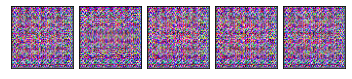

--- EPOCH 2/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.47it/s]
Discriminator loss: 0.09193607494235038
Generator loss:     9.526159715652465
Saved checkpoint.


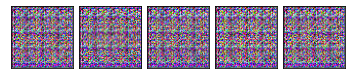

--- EPOCH 3/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.46it/s]
Discriminator loss: 0.13939451910555362
Generator loss:     13.934830617904662
Saved checkpoint.


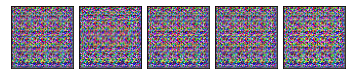

--- EPOCH 4/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.61it/s]
Discriminator loss: 0.4093686668202281
Generator loss:     14.056299686431885
Saved checkpoint.


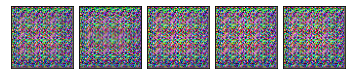

--- EPOCH 5/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.34it/s]
Discriminator loss: 0.24055160833522676
Generator loss:     15.968682956695556
Saved checkpoint.


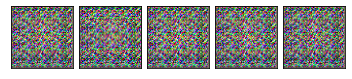

--- EPOCH 6/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.23it/s]
Discriminator loss: 0.22288390770554542
Generator loss:     14.220499563217164
Saved checkpoint.


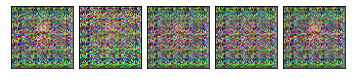

--- EPOCH 7/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.54it/s]
Discriminator loss: 0.5930101927369833
Generator loss:     14.696264934539794
Saved checkpoint.


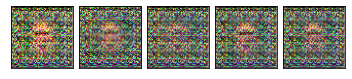

--- EPOCH 8/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.61it/s]
Discriminator loss: 0.4486813494935632
Generator loss:     11.324059295654298
Saved checkpoint.


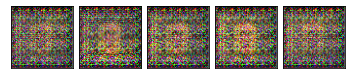

--- EPOCH 9/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.48it/s]
Discriminator loss: 0.8660089176148176
Generator loss:     9.878724622726441
Saved checkpoint.


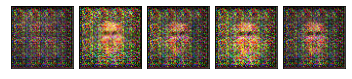

--- EPOCH 10/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.42it/s]
Discriminator loss: 0.3883671049028635
Generator loss:     7.03171820640564
Saved checkpoint.


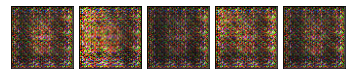

--- EPOCH 11/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.39it/s]
Discriminator loss: 0.23645944371819497
Generator loss:     6.332311773300171
Saved checkpoint.


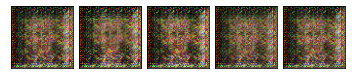

--- EPOCH 12/100 ---
100%|██████████| 10/10 [00:02<00:00,  4.96it/s]
Discriminator loss: 0.3220749020576477
Generator loss:     7.349650621414185
Saved checkpoint.


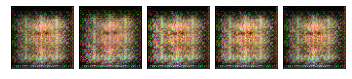

--- EPOCH 13/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.44it/s]
Discriminator loss: 1.5211268782615661
Generator loss:     8.419713592529297
Saved checkpoint.


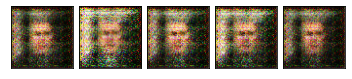

--- EPOCH 14/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.64it/s]
Discriminator loss: 1.0495236992836
Generator loss:     5.45401782989502
Saved checkpoint.


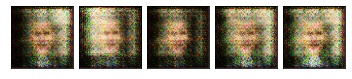

--- EPOCH 15/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.24it/s]
Discriminator loss: 0.691322284936905
Generator loss:     3.937280571460724
Saved checkpoint.


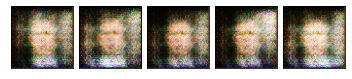

--- EPOCH 16/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.50it/s]
Discriminator loss: 0.7622922658920288
Generator loss:     3.553904151916504
Saved checkpoint.


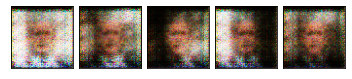

--- EPOCH 17/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.57it/s]
Discriminator loss: 0.4603357553482056
Generator loss:     3.3042343139648436
Saved checkpoint.


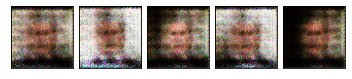

--- EPOCH 18/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.91it/s]
Discriminator loss: 0.4481253415346146
Generator loss:     3.969195508956909
Saved checkpoint.


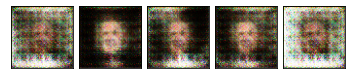

--- EPOCH 19/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.50it/s]
Discriminator loss: 0.35422549992799757
Generator loss:     4.596952438354492
Saved checkpoint.


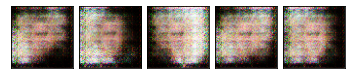

--- EPOCH 20/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.51it/s]
Discriminator loss: 1.370464664697647
Generator loss:     3.220873510837555
Saved checkpoint.


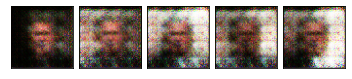

--- EPOCH 21/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.30it/s]
Discriminator loss: 0.7079263150691986
Generator loss:     2.8276012182235717
Saved checkpoint.


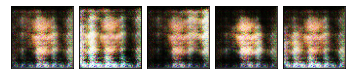

--- EPOCH 22/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.57it/s]
Discriminator loss: 0.40842372328042986
Generator loss:     3.7172066926956178
Saved checkpoint.


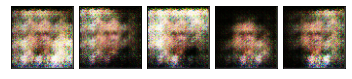

--- EPOCH 23/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.63it/s]
Discriminator loss: 0.39587933123111724
Generator loss:     3.8903827905654906
Saved checkpoint.


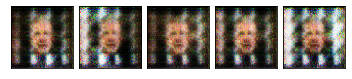

--- EPOCH 24/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.59it/s]
Discriminator loss: 0.46018512099981307
Generator loss:     4.377999424934387
Saved checkpoint.


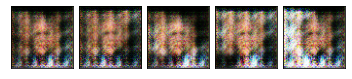

--- EPOCH 25/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.32it/s]
Discriminator loss: 0.6365256190299988
Generator loss:     4.783690118789673
Saved checkpoint.


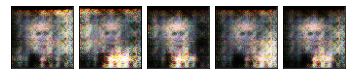

--- EPOCH 26/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.62it/s]
Discriminator loss: 0.7630019500851631
Generator loss:     5.075119543075561
Saved checkpoint.


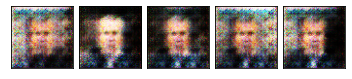

--- EPOCH 27/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.39it/s]
Discriminator loss: 0.6420430183410645
Generator loss:     4.852909731864929
Saved checkpoint.


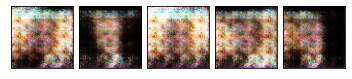

--- EPOCH 28/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.54it/s]
Discriminator loss: 0.46531751453876496
Generator loss:     4.1409300565719604
Saved checkpoint.


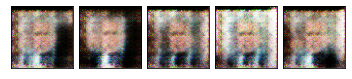

--- EPOCH 29/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.30it/s]
Discriminator loss: 0.5275893464684487
Generator loss:     4.277007460594177
Saved checkpoint.


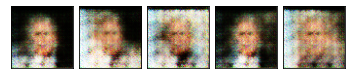

--- EPOCH 30/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.33it/s]
Discriminator loss: 0.5113429844379425
Generator loss:     4.769099569320678
Saved checkpoint.


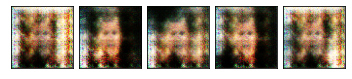

--- EPOCH 31/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.64it/s]
Discriminator loss: 0.42299750745296477
Generator loss:     4.439977216720581
Saved checkpoint.


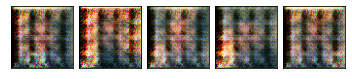

--- EPOCH 32/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.29it/s]
Discriminator loss: 0.2492222845554352
Generator loss:     4.854667377471924
Saved checkpoint.


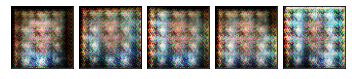

--- EPOCH 33/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.59it/s]
Discriminator loss: 1.305269305408001
Generator loss:     5.265974885225296
Saved checkpoint.


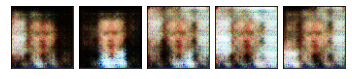

--- EPOCH 34/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.47it/s]
Discriminator loss: 0.7053071022033691
Generator loss:     3.951119589805603
Saved checkpoint.


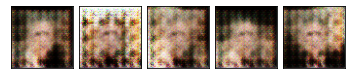

--- EPOCH 35/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.39it/s]
Discriminator loss: 0.41853785812854766
Generator loss:     4.3705018043518065
Saved checkpoint.


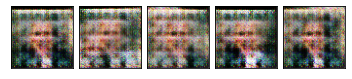

--- EPOCH 36/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.32it/s]
Discriminator loss: 0.4420906901359558
Generator loss:     4.801820611953735
Saved checkpoint.


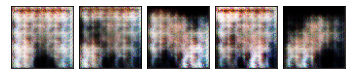

--- EPOCH 37/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.55it/s]
Discriminator loss: 0.7819073170423507
Generator loss:     4.759429025650024
Saved checkpoint.


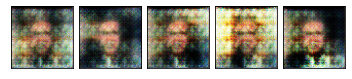

--- EPOCH 38/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.33it/s]
Discriminator loss: 0.3886368960142136
Generator loss:     4.1428638935089115
Saved checkpoint.


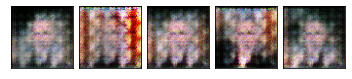

--- EPOCH 39/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.51it/s]
Discriminator loss: 0.6352692797780037
Generator loss:     5.341770648956299
Saved checkpoint.


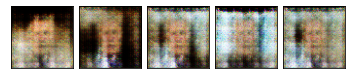

--- EPOCH 40/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.49it/s]
Discriminator loss: 0.5298883587121963
Generator loss:     4.004298663139343
Saved checkpoint.


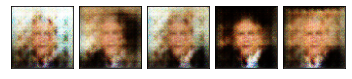

--- EPOCH 41/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.54it/s]
Discriminator loss: 0.622650197148323
Generator loss:     3.931332552433014
Saved checkpoint.


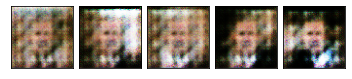

--- EPOCH 42/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.40it/s]
Discriminator loss: 0.4422264963388443
Generator loss:     3.804478669166565
Saved checkpoint.


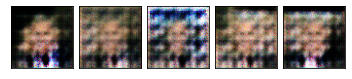

--- EPOCH 43/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.42it/s]
Discriminator loss: 0.6518501713871956
Generator loss:     6.327693772315979
Saved checkpoint.


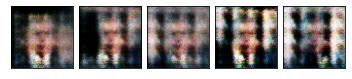

--- EPOCH 44/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.03it/s]
Discriminator loss: 0.7456848919391632
Generator loss:     4.6785900592803955
Saved checkpoint.


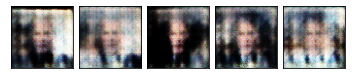

--- EPOCH 45/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.61it/s]
Discriminator loss: 0.5494100138545036
Generator loss:     3.951957035064697
Saved checkpoint.


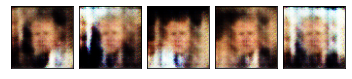

--- EPOCH 46/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.51it/s]
Discriminator loss: 0.4003695249557495
Generator loss:     4.143571448326111
Saved checkpoint.


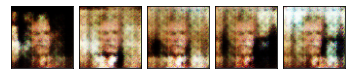

--- EPOCH 47/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.56it/s]
Discriminator loss: 0.7180007189512253
Generator loss:     5.228805613517761
Saved checkpoint.


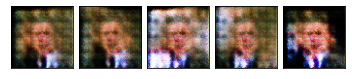

--- EPOCH 48/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.57it/s]
Discriminator loss: 0.37154038846492765
Generator loss:     4.074751782417297
Saved checkpoint.


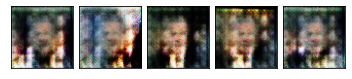

--- EPOCH 49/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.48it/s]
Discriminator loss: 0.6322001308202744
Generator loss:     4.484398555755615
Saved checkpoint.


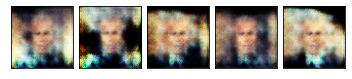

--- EPOCH 50/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.62it/s]
Discriminator loss: 0.4997472256422043
Generator loss:     3.9981088638305664
Saved checkpoint.


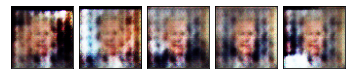

--- EPOCH 51/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.45it/s]
Discriminator loss: 0.40403514802455903
Generator loss:     4.308803844451904
Saved checkpoint.


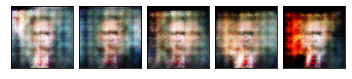

--- EPOCH 52/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.47it/s]
Discriminator loss: 0.9259357899427414
Generator loss:     4.5109625339508055
Saved checkpoint.


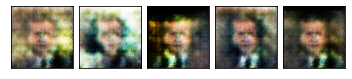

--- EPOCH 53/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.47it/s]
Discriminator loss: 0.7578444689512253
Generator loss:     4.174215054512024
Saved checkpoint.


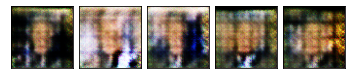

--- EPOCH 54/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.56it/s]
Discriminator loss: 0.5399625897407532
Generator loss:     3.963290047645569
Saved checkpoint.


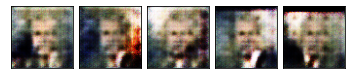

--- EPOCH 55/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.48it/s]
Discriminator loss: 0.5133930712938308
Generator loss:     3.956071877479553
Saved checkpoint.


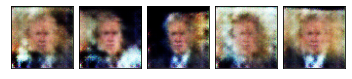

--- EPOCH 56/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.47it/s]
Discriminator loss: 1.001721489429474
Generator loss:     4.195303416252136
Saved checkpoint.


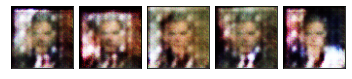

--- EPOCH 57/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.36it/s]
Discriminator loss: 0.6203892022371292
Generator loss:     3.864204835891724
Saved checkpoint.


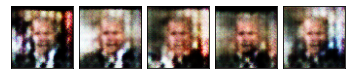

--- EPOCH 58/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.32it/s]
Discriminator loss: 0.5885673731565475
Generator loss:     3.7907255411148073
Saved checkpoint.


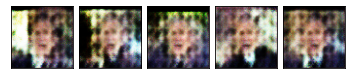

--- EPOCH 59/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.44it/s]
Discriminator loss: 0.5384043395519257
Generator loss:     3.867596459388733
Saved checkpoint.


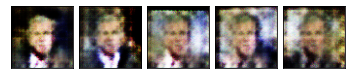

--- EPOCH 60/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.49it/s]
Discriminator loss: 1.172151257097721
Generator loss:     4.344737541675568
Saved checkpoint.


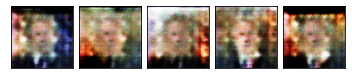

--- EPOCH 61/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.16it/s]
Discriminator loss: 0.510345920920372
Generator loss:     3.473881196975708
Saved checkpoint.


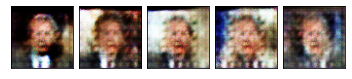

--- EPOCH 62/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.59it/s]
Discriminator loss: 0.5551829814910889
Generator loss:     3.6468932271003722
Saved checkpoint.


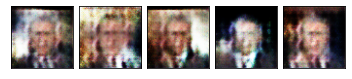

--- EPOCH 63/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.36it/s]
Discriminator loss: 0.49236033856868744
Generator loss:     3.8730894804000853
Saved checkpoint.


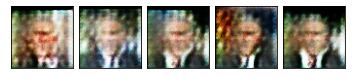

--- EPOCH 64/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.46it/s]
Discriminator loss: 0.539186704158783
Generator loss:     4.239470672607422
Saved checkpoint.


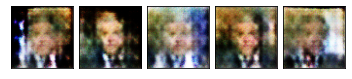

--- EPOCH 65/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.31it/s]
Discriminator loss: 0.6699506133794785
Generator loss:     4.643010199069977
Saved checkpoint.


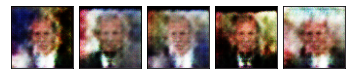

--- EPOCH 66/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.51it/s]
Discriminator loss: 0.4911049693822861
Generator loss:     3.812856709957123
Saved checkpoint.


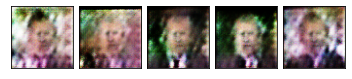

--- EPOCH 67/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.28it/s]
Discriminator loss: 0.8409231692552567
Generator loss:     4.562450802326202
Saved checkpoint.


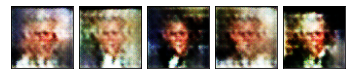

--- EPOCH 68/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.50it/s]
Discriminator loss: 0.691846364736557
Generator loss:     4.019660806655883
Saved checkpoint.


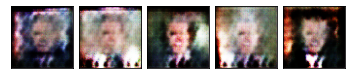

--- EPOCH 69/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.49it/s]
Discriminator loss: 0.4629361480474472
Generator loss:     4.14177713394165
Saved checkpoint.


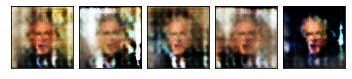

--- EPOCH 70/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.47it/s]
Discriminator loss: 0.44266740679740907
Generator loss:     3.816788911819458
Saved checkpoint.


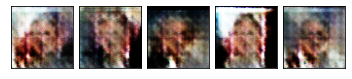

--- EPOCH 71/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.48it/s]
Discriminator loss: 0.6191422432661057
Generator loss:     4.367124414443969
Saved checkpoint.


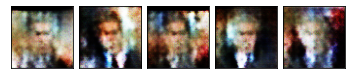

--- EPOCH 72/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.51it/s]
Discriminator loss: 0.40063396096229553
Generator loss:     3.8231416940689087
Saved checkpoint.


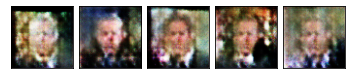

--- EPOCH 73/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.35it/s]
Discriminator loss: 0.7849635899066925
Generator loss:     4.402693420648575
Saved checkpoint.


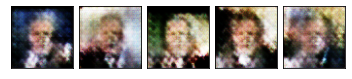

--- EPOCH 74/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.50it/s]
Discriminator loss: 0.7921128928661346
Generator loss:     3.9581161737442017
Saved checkpoint.


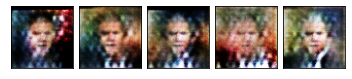

--- EPOCH 75/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.58it/s]
Discriminator loss: 0.5605507612228393
Generator loss:     3.889804649353027
Saved checkpoint.


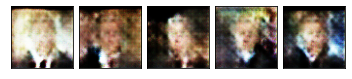

--- EPOCH 76/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.47it/s]
Discriminator loss: 0.4877692610025406
Generator loss:     4.288616669178009
Saved checkpoint.


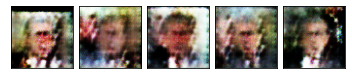

--- EPOCH 77/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.49it/s]
Discriminator loss: 0.44127628207206726
Generator loss:     3.7211917638778687
Saved checkpoint.


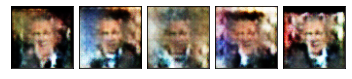

--- EPOCH 78/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.54it/s]
Discriminator loss: 0.6970952540636063
Generator loss:     4.521294808387756
Saved checkpoint.


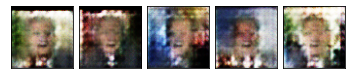

--- EPOCH 79/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.48it/s]
Discriminator loss: 0.5948670029640197
Generator loss:     3.8478401064872743
Saved checkpoint.


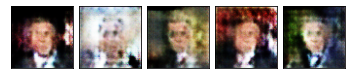

--- EPOCH 80/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.44it/s]
Discriminator loss: 0.7207067310810089
Generator loss:     3.8928138494491575
Saved checkpoint.


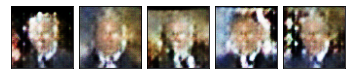

--- EPOCH 81/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.59it/s]
Discriminator loss: 0.45029019117355346
Generator loss:     3.8613991498947144
Saved checkpoint.


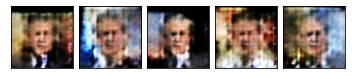

--- EPOCH 82/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.45it/s]
Discriminator loss: 0.4213254779577255
Generator loss:     4.337159156799316
Saved checkpoint.


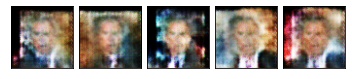

--- EPOCH 83/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.56it/s]
Discriminator loss: 0.38276842087507246
Generator loss:     4.16409432888031
Saved checkpoint.


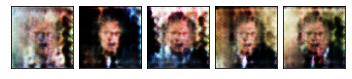

--- EPOCH 84/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.47it/s]
Discriminator loss: 0.9902405917644501
Generator loss:     4.9258839130401615
Saved checkpoint.


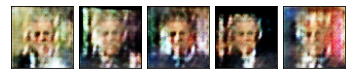

--- EPOCH 85/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.48it/s]
Discriminator loss: 0.48911584317684176
Generator loss:     3.9616673946380616
Saved checkpoint.


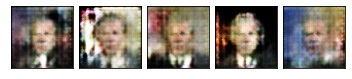

--- EPOCH 86/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.60it/s]
Discriminator loss: 0.4845471173524857
Generator loss:     4.016266894340515
Saved checkpoint.


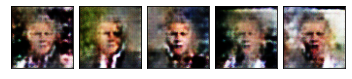

--- EPOCH 87/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.19it/s]
Discriminator loss: 0.428146043419838
Generator loss:     3.909480929374695
Saved checkpoint.


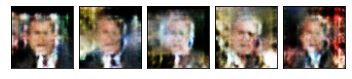

--- EPOCH 88/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.40it/s]
Discriminator loss: 0.5918529689311981
Generator loss:     4.2207036972045895
Saved checkpoint.


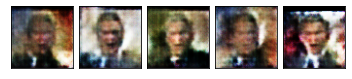

--- EPOCH 89/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.36it/s]
Discriminator loss: 0.40025831907987597
Generator loss:     3.702199625968933
Saved checkpoint.


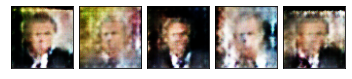

--- EPOCH 90/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.58it/s]
Discriminator loss: 0.4220940828323364
Generator loss:     3.8011820793151854
Saved checkpoint.


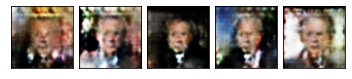

--- EPOCH 91/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.54it/s]
Discriminator loss: 0.7935896784067153
Generator loss:     4.574920380115509
Saved checkpoint.


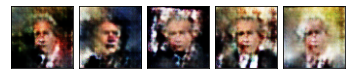

--- EPOCH 92/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
Discriminator loss: 0.3964881241321564
Generator loss:     3.596937525272369
Saved checkpoint.


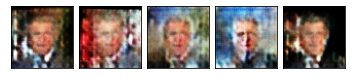

--- EPOCH 93/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.51it/s]
Discriminator loss: 0.4627633035182953
Generator loss:     3.8546897411346435
Saved checkpoint.


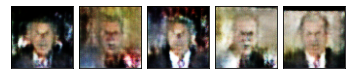

--- EPOCH 94/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.54it/s]
Discriminator loss: 0.42082132697105407
Generator loss:     3.854617691040039
Saved checkpoint.


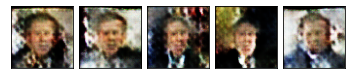

--- EPOCH 95/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.26it/s]
Discriminator loss: 0.3903347045183182
Generator loss:     3.7933247923851012
Saved checkpoint.


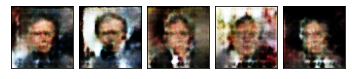

--- EPOCH 96/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.12it/s]
Discriminator loss: 0.8903836593031883
Generator loss:     4.304650139808655
Saved checkpoint.


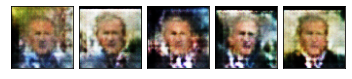

--- EPOCH 97/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.48it/s]
Discriminator loss: 0.40191974937915803
Generator loss:     3.916739320755005
Saved checkpoint.


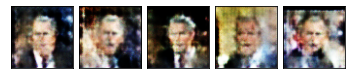

--- EPOCH 98/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.53it/s]
Discriminator loss: 0.4999188810586929
Generator loss:     4.040491652488709
Saved checkpoint.


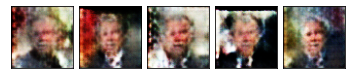

--- EPOCH 99/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.27it/s]
Discriminator loss: 0.3441234350204468
Generator loss:     3.615295433998108
Saved checkpoint.


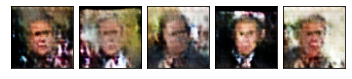

--- EPOCH 100/100 ---
100%|██████████| 10/10 [00:01<00:00,  5.56it/s]
Discriminator loss: 0.4778635576367378
Generator loss:     3.7648980975151063
Saved checkpoint.


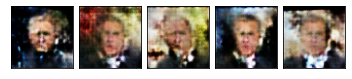

In [16]:
import IPython.display
import tqdm
from hw3.gan import train_batch, save_checkpoint

num_epochs = 100

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    num_epochs = 0
    gen = torch.load(f'{checkpoint_file_final}.pt', map_location=device)
    checkpoint_file = checkpoint_file_final

try:
    dsc_avg_losses, gen_avg_losses = [], []
    for epoch_idx in range(num_epochs):
        # We'll accumulate batch losses and show an average once per epoch.
        dsc_losses, gen_losses = [], []
        print(f'--- EPOCH {epoch_idx+1}/{num_epochs} ---')

        with tqdm.tqdm(total=len(dl_train.batch_sampler), file=sys.stdout) as pbar:
            for batch_idx, (x_data, _) in enumerate(dl_train):
                x_data = x_data.to(device)
                dsc_loss, gen_loss = train_batch(
                    dsc, gen,
                    dsc_loss_fn, gen_loss_fn,
                    dsc_optimizer, gen_optimizer,
                    x_data)
                dsc_losses.append(dsc_loss)
                gen_losses.append(gen_loss)
                pbar.update()

        dsc_avg_losses.append(np.mean(dsc_losses))
        gen_avg_losses.append(np.mean(gen_losses))
        print(f'Discriminator loss: {dsc_avg_losses[-1]}')
        print(f'Generator loss:     {gen_avg_losses[-1]}')
        
        if save_checkpoint(gen, dsc_avg_losses, gen_avg_losses, checkpoint_file):
            print(f'Saved checkpoint.')
            

        samples = gen.sample(5, with_grad=False)
        fig, _ = plot.tensors_as_images(samples.cpu(), figsize=(6,2))
        IPython.display.display(fig)
        plt.close(fig)
except KeyboardInterrupt as e:
    print('\n *** Training interrupted by user')

*** Images Generated from best model:


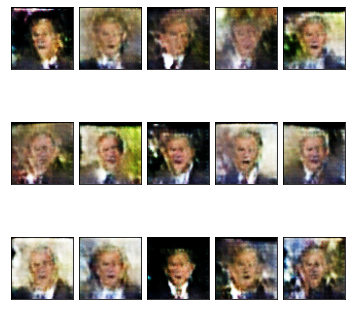

In [13]:
# Plot images from best or last model
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(6,6))

## Questions
<a id=part3_8></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [15]:
from cs236781.answers import display_answer
import hw3.answers

### Question 1

Explain in detail why during training we sometimes need to maintain gradients when sampling from the GAN,
and other times we don't. When are they maintained and why? When are they discarded and why?

In [16]:
display_answer(hw3.answers.part3_q1)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 2

1. When training a GAN to generate images, should we decide to stop training solely based on the fact that  the Generator loss is below some threshold?
Why or why not?

2. What does it mean if the discriminator loss remains at a constant value while the generator loss decreases?

In [17]:
display_answer(hw3.answers.part3_q2)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$



### Question 3

Compare the results you got when generating images with the VAE to the GAN results.
What's the main difference and what's causing it?

In [18]:
display_answer(hw3.answers.part3_q3)


**Your answer:**


Write your answer using **markdown** and $\LaTeX$:
```python
# A code block
a = 2
```
An equation: $e^{i\pi} -1 = 0$

